# Feature Importance -- Deeplift

## Load and perpare data

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
# np.random.seed(12345) # Set seed

import pandas as pd
from imblearn.combine import SMOTEENN 
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.utils import resample
from keras.layers import Dense,BatchNormalization,Input,Convolution1D,GRU,Dropout
#from keras.models import Model
import keras
#import pdb
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
import warnings
import matplotlib.pyplot as plt
import deeplift

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


data obtained earlier using Michael's code:

In [2]:
collapsed_shifted = pd.read_csv('collapsed_shifted.csv',index_col=0)
event_idx = pd.read_csv('event_idx.csv',header=None,index_col=0)

In [3]:
print ('Creating train test split...')
X_train,X_test,Y_train,Y_test = train_test_split(collapsed_shifted,event_idx,stratify=None,test_size=.20,shuffle=False)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.20,stratify=None,shuffle=False)

#Creating Copies of Data Frames these will be useful later for debugging
X_train_df = X_train.copy(True)
Y_train_df = Y_train.copy(True)
Y_val_df = Y_val.copy(True)
X_train  = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

Creating train test split...


In [4]:
#pca = PCA(whiten=True)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)
#X_val = pca.transform(X_val)

print ('Length of X_train before smote')
print (len(X_train))
print ('Number of Positives before smote')
print (Y_train.sum())


print ('Performing Oversampling/Undersampling...')
s = SMOTEENN()
X_train,Y_train= s.fit_sample(X_train,Y_train)

print ('Length of X_train after smote')
print (len(X_train))

print ('Number of Positive samples after smote')
print (Y_train.sum())

# print ('Proportion after smote {}'.format(sum(Y_train)/len(Y_train))

X_train = X_train.reshape(-1,X_train.shape[1],1)
X_test = X_test.reshape(-1,X_test.shape[1],1)
X_val = X_val.reshape(-1,X_val.shape[1],1)
print ('Done!')

Length of X_train before smote
2780
Number of Positives before smote
1    166
dtype: int64
Performing Oversampling/Undersampling...


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Length of X_train after smote
4584
Number of Positive samples after smote
2572
Done!


## Keras Model

Rewrite it to be compatiable with Deeplift.

There is no MaxoutDense in the Deeplift conversion part, so I skipped them for now.

In [5]:
#from keras.regularizers import l1l2
from keras.constraints import maxnorm
from keras.layers import MaxoutDense
from keras.layers import Flatten
from keras.layers import MaxPooling1D

def simple_keras_model(original):
    model = Sequential()
    model.add(Convolution1D(512, 5, border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5),input_shape =(original.shape[1],1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
    model.add(Dropout(.55))
    model.add(Convolution1D(512,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
    model.add(Dropout(.55))
    model.add(Convolution1D(256,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5)))
    model.add(BatchNormalization())
    model.add(Dropout(.55))
    model.add(Convolution1D(128,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5)))
    model.add(BatchNormalization())
    model.add(Dropout(.55))
    model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(.35))
    model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(.35))
    model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(.35))
    model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(.35))
    
    
    
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    
    
    #my_model = Model([original_input], output=output)
    optimizer_adam = keras.optimizers.adam(0.001) 
    model.compile(loss='binary_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])

    return(model)


In [6]:
import tensorflow as tf
from keras.models import Sequential
my_model = simple_keras_model(X_train)
my_model.fit(X_train,Y_train,nb_epoch=20,batch_size=128)

Epoch 1/20
4584/4584 [==============================] - 48s - loss: 0.6770 - acc: 0.6915    
Epoch 2/20
4584/4584 [==============================] - 44s - loss: 0.4884 - acc: 0.7694    
Epoch 3/20
4584/4584 [==============================] - 47s - loss: 0.4265 - acc: 0.8072    
Epoch 4/20
4584/4584 [==============================] - 47s - loss: 0.3822 - acc: 0.8325    
Epoch 5/20
4584/4584 [==============================] - 47s - loss: 0.3264 - acc: 0.8634    
Epoch 6/20
4584/4584 [==============================] - 44s - loss: 0.2799 - acc: 0.8874    
Epoch 7/20
4584/4584 [==============================] - 43s - loss: 0.2641 - acc: 0.8979    
Epoch 8/20
4584/4584 [==============================] - 43s - loss: 0.2263 - acc: 0.9119    
Epoch 9/20
4584/4584 [==============================] - 43s - loss: 0.1950 - acc: 0.9282    
Epoch 10/20
4584/4584 [==============================] - 44s - loss: 0.1827 - acc: 0.9295    
Epoch 11/20
4584/4584 [==============================] - 48s - loss: 

In [7]:
my_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_1 (Convolution1D)  (None, 18, 512)       3072        convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 18, 512)       2048        convolution1d_1[0][0]            
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)    (None, 9, 512)        0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 9, 512)        0           maxpooling1d_1[0][0]             
___________________________________________________________________________________________

## Deeplift

Adjusted from the code provided by the authors of the paper [https://arxiv.org/abs/1704.02685]:
https://github.com/kundajelab/deeplift/blob/tensorflow/deeplift/conversion/keras_conversion.py

In [8]:
#Convert a keras sequential model
import deeplift
from deeplift.conversion import keras_conversion as kc
#MxtsMode defines the method for computing importance scores. Other supported values are:
#Gradient, DeconvNet, GuidedBackprop and GuidedBackpropDeepLIFT (a hybrid of GuidedBackprop and DeepLIFT where
#negative multipliers are ignored during backpropagation)
deeplift_model = kc.convert_sequential_model(
                    my_model,
                    nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT)

#Specify the index of the layer to compute the importance scores of.
#In the example below, we find scores for the input layer, which is idx 0 in deeplift_model.get_layers()
find_scores_layer_idx = 0

#Compile the function that computes the importance scores
#For sigmoid or softmax outputs, target_layer_idx should be -2 (the default)
#(See "a note on final activation layers" in https://arxiv.org/pdf/1605.01713v2.pdf for justification)
#For regression tasks with a linear output, target_layer_idx should be -1
#(which simply refers to the last layer)
#FYI: In the case of MxtsMode.DeepLIFT, the importance scores are also called "contribution scores"
#If you want the multipliers instead of the contribution scores, you can use get_target_multipliers_func
deeplift_contribs_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx=find_scores_layer_idx,
                            target_layer_idx=-2)

#compute scores on inputs
#input_data_list is a list containing the data for different input layers
#eg: for MNIST, there is one input layer with with dimensions 1 x 28 x 28
#In the example below, let X be an array with dimension n x 1 x 28 x 28 where n is the number of examples
#task_idx represents the index of the node in the output layer that we wish to compute scores.
#Eg: if the output is a 10-way softmax, and task_idx is 0, we will compute scores for the first softmax class
scores = np.array(deeplift_contribs_func(task_idx=0,
                                         input_data_list=[X_train],
                                         batch_size=10,
                                         progress_update=1000))

No reference provided - using zeros
Done 0
Done 1000
Done 2000
Done 3000
Done 4000


In [9]:
s = scores.reshape([scores.shape[0],scores.shape[1]])

## Results

In [10]:
X_train_df.columns

Index(['GoldsteinScale', 'NumMentions', 'avgtone', 'numarticles', 'numsources',
       'wit_co', 'unemploy', 'm1v', 'm2v', 'slsi', 'vix', 'dff', 'Open',
       'High', 'Low', 'Close', 'Adj Close', 'Volume'],
      dtype='object')

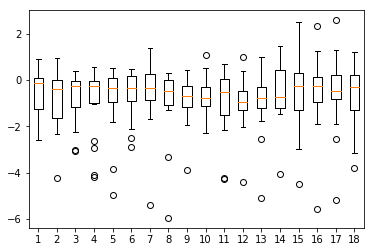

In [11]:
plt.figure()
data=[s[i] for i in range(18)]
plt.boxplot(data)
plt.show()

In [12]:
score_mean = s.mean(axis=0)
mean_df = pd.DataFrame(score_mean).T
mean_df.columns = X_train_df.columns

In [13]:
mean_df.T.sort_values(by=0)

,0
m1v,-0.955749
wit_co,-0.827570
unemploy,-0.769877
avgtone,-0.611026
GoldsteinScale,-0.576863
dff,-0.528706
NumMentions,-0.507259
m2v,-0.490341
numsources,-0.237641
numarticles,-0.120099


In [14]:
mean_df.abs().T.sort_values(by=0)

,0
Low,0.043340
Open,0.054194
Close,0.073034
vix,0.114447
numarticles,0.120099
Volume,0.164820
numsources,0.237641
High,0.342061
Adj Close,0.448655
slsi,0.490104


It seems that sentiment features like 'GoldsteinScale' and 'avgtone' are more important than volume features. But finanical features like 'unemploy' and 'wit_co' are even more important than these sentiment metrics.